# Basic Model Testing

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

In [2]:
mod1 = torch.load(sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')

In [3]:
for name in mod1['state_dict']:
    print(name)

module.conv1.weight
module.bn1.weight
module.bn1.bias
module.bn1.running_mean
module.bn1.running_var
module.bn1.num_batches_tracked
module.layer1.0.conv1.weight
module.layer1.0.bn1.weight
module.layer1.0.bn1.bias
module.layer1.0.bn1.running_mean
module.layer1.0.bn1.running_var
module.layer1.0.bn1.num_batches_tracked
module.layer1.0.conv2.weight
module.layer1.0.bn2.weight
module.layer1.0.bn2.bias
module.layer1.0.bn2.running_mean
module.layer1.0.bn2.running_var
module.layer1.0.bn2.num_batches_tracked
module.layer1.1.conv1.weight
module.layer1.1.bn1.weight
module.layer1.1.bn1.bias
module.layer1.1.bn1.running_mean
module.layer1.1.bn1.running_var
module.layer1.1.bn1.num_batches_tracked
module.layer1.1.conv2.weight
module.layer1.1.bn2.weight
module.layer1.1.bn2.bias
module.layer1.1.bn2.running_mean
module.layer1.1.bn2.running_var
module.layer1.1.bn2.num_batches_tracked
module.layer2.0.conv1.weight
module.layer2.0.bn1.weight
module.layer2.0.bn1.bias
module.layer2.0.bn1.running_mean
module.lay

# Loading the Dataset

In [4]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [5]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [6]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

In [7]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

Create opt for passing to the constructor. \
Also pass a string with the training value

## Loading Full Dataset

In [8]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=13.95s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [9]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287


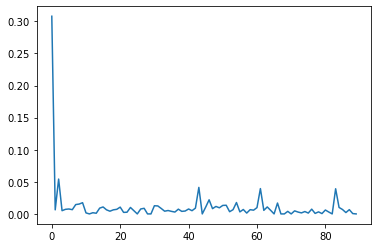

In [10]:
N=512
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [11]:
opt.num_iters = dataset.num_samples/opt.batch_size
#print(dataset.images)

## Dataloader

In [12]:
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [13]:
val_loader = torch.utils.data.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

# Model

In [14]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [15]:
# regression on center point.
model = create_model(opt.arch, opt.heads, opt.head_conv)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


In [16]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Trainer

In [17]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

# Running main training loop

In [18]:
## Test for Using their train function from Ctdetrainer
# print('Starting training...')
# best = 1e10
# for epoch in range(start_epoch + 1, opt.num_epochs + 1):
#     log_dict_train, _ = trainer.train(epoch, train_loader)
    

In [19]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [24]:
for name,param in model.named_parameters():
    if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
        print(param.size())
        print(torch.randn(param.size()))
    else:
        param.requires_grad=False

torch.Size([64, 256, 3, 3])
tensor([[[[ 0.7098,  0.9155, -0.0470],
          [-0.9024, -1.2803, -0.9522],
          [-0.1097, -0.0580, -0.5490]],

         [[ 1.6454, -0.7172, -0.3062],
          [ 0.8657,  0.4802,  2.1133],
          [-1.1770, -0.1886, -1.0069]],

         [[-0.6282,  0.7085,  0.2785],
          [ 0.2698,  0.1552,  0.5249],
          [ 0.8899,  0.4686,  0.5808]],

         ...,

         [[-0.0514,  0.6435, -0.6541],
          [ 1.0031, -0.1310,  0.1343],
          [ 0.3432, -1.0862, -0.3013]],

         [[-0.5832, -0.6877, -0.7510],
          [-0.2117,  0.6613,  0.0299],
          [ 0.6465,  0.5882,  0.1423]],

         [[ 0.6736,  0.9484, -0.2857],
          [-1.2885, -0.5833,  0.8693],
          [-0.9782, -0.8043, -0.1049]]],


        [[[ 0.1135, -1.7704, -2.9050],
          [-1.3069,  0.2337, -0.3591],
          [-1.4984,  1.2009, -1.0487]],

         [[ 1.6632, -1.2490,  1.8448],
          [-0.4026, -0.5488,  0.9926],
          [ 0.4975,  0.0239,  2.4253]],

   

In [25]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param = torch.randn(param.size()) # Random initialization
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [26]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    #image=np.int(((image-np.min(image))/(np.max(image)-np.min(image)))*255)
    #print(image.shape)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [29]:
model1 =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net = Centernet_model(opt,model1);
net = net.to(opt.device)
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

loaded /datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140
Skip loading parameter deconv_layers.0.weight, required shapetorch.Size([512, 256, 4, 4]), loaded shapetorch.Size([256, 512, 3, 3]). If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
Drop parameter deconv_layers.0.bias.If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
Drop parameter deconv_layers.0.conv_offset_mask.weight.If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
Drop parameter deconv_layers.0.conv_offset_mask.bias.If you see this, your model do

## Data Augmentation

In [ ]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    print(idx)
    x1=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x1[0,:,:,:])
    print(x1[0,:,:,:].shape,I.shape)

In [ ]:
torch.equal(x,x1)
print()

In [ ]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    x=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x[0,:,:,:])
    print(x[0,:,:,:].shape,I.shape)

## Manual Batch Loss computation

In [27]:
for idx,batch in enumerate(train_loader):
    #print(idx)
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=opt.device, non_blocking=True) 
    y=net.model(batch['input'])
    #y=net.model(batch['input'])
    #batch = batch.to(net.device)
    #y,_,_=net.model_with_loss(batch)
    #print(idx)
    loss1,_ = net.loss(y,batch)

NameError: name 'net' is not defined

In [ ]:
print(loss1.mean())

In [31]:
for name,param in net.model.named_parameters():
    print(name,param.size(),param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn1.weight torch.Size([64]) False
layer1.0.bn1.bias torch.Size([64]) False
layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn2.weight torch.Size([64]) False
layer1.0.bn2.bias torch.Size([64]) False
layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn1.weight torch.Size([64]) False
layer1.1.bn1.bias torch.Size([64]) False
layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn2.weight torch.Size([64]) False
layer1.1.bn2.bias torch.Size([64]) False
layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) False
layer2.0.bn1.weight torch.Size([128]) False
layer2.0.bn1.bias torch.Size([128]) False
layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer2.0.bn2.weight torch.Size([128]) False
layer2.0.bn2.bias torch.Size([128]) False
layer2.0.downsample.0.weight torch.Size([128, 64

## Experiment with custom function run2

In [32]:
adam = torch.optim.Adam(net.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp2 = nt.Experiment(net,dataset,valset,adam,stats_manager,
output_dir="BaseExperiment", batch_size=opt.batch_size,perform_validation_during_training=False)

In [33]:
exp2.run2(num_epochs=5)

Start/Continue training from epoch 0


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1 (Time: 50.99s)
Epoch 2 (Time: 49.48s)
Epoch 3 (Time: 50.11s)
Epoch 4 (Time: 51.26s)
Epoch 5 (Time: 49.50s)
Finish training for 5 epochs


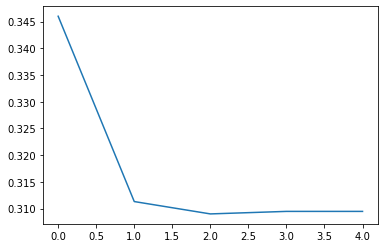

In [34]:
plt.plot(exp2.history)
plt.show()